# Simple ANN with MNIST

## Data Loading

In [1]:
import torch
from torchvision import datasets, transforms

'''
  This code is used to download the dataset which is already splitted
  into a training  set and a testing set.
  Note that we apply simple transformation to the data to convert them
  into PyTorch Tensors and to normalize the pixel values entries in a 
  specific range of values. 
'''

transform_actions = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))
    ]
)

mnist_trainset = datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform = transform_actions
)
    
mnist_testset = datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform = transform_actions
)


print("Training set size: ", len(mnist_trainset))
print("Testing set size : ", len(mnist_testset))

# we define a loader and an iterator to process the training set
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:01<00:00, 9072282.27it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 1853900.21it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 9711161.97it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Training set size:  60000
Testing set size :  10000


Images shape:  torch.Size([64, 1, 28, 28])
Each batch contains 64 images, for which 1 channel of size 28 x 28 is defined 


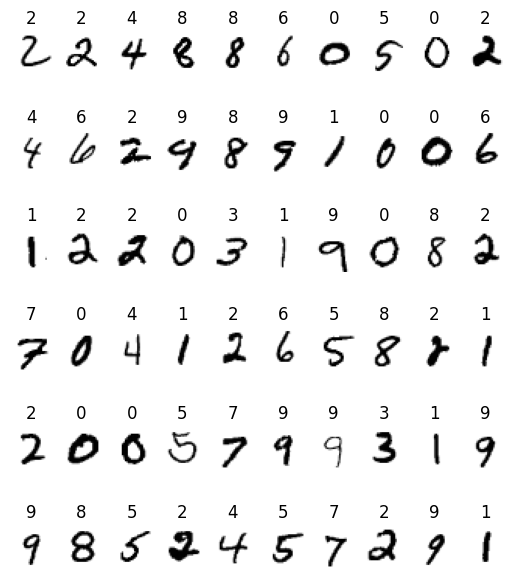

In [4]:
import matplotlib.pyplot as plt

images, labels = next(iter(trainloader))

print("Images shape: ", images.shape)
print("Each batch contains {} images, for which {} channel of size {} x {} is defined ".format(*images.shape))

# The following code is just used to plot
figure = plt.figure()
plt.subplots_adjust(top=5.2, bottom=4) 
num_of_images = 60
for index in range(0, num_of_images):
    plt.subplot(6, 10, index+1)
    plt.axis('off')
    plt.gca().set_title(labels[index].item())
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Simple ANN model

We will introduce a simple ANN considering: 
* That we will flatten the input data, i.e. represent the pixel values of a matrix as a vector of values. 
* Two hidden layers

Note that we are dealing with a multiclass classification task. 
Processing an input, the output of our network will therefore be a probability distribution that will give the probability for each classes (10 possible classes in this case).  

In [5]:
D_in = 28 * 28 # input dimension
D_out = 10     # output dimension

# Numbers of neurons for the two layers
H = 1000
H2 = 500

# Model definition using sequential
model = torch.nn.Sequential(
    torch.nn.Flatten(),        # first the input is flatten, output will be a vector of size dim(1) x ... x dim(-1), here 1 x 28 x 28 = 784
    torch.nn.Linear(D_in, H),  # Linear transformation 128 to H (num neurons Layer 1)
    torch.nn.ReLU(),           # activation function layer 1
    torch.nn.Linear(H, H2),    # Linear transformation H to H2 (num neurons Layer 2)
    torch.nn.ReLU(),           # activation function layer 2
    torch.nn.Linear(H2, D_out),# Linear transformation for the output H2 x D_out
    #torch.nn.Softmax(dim=1)   # Softmax of the D_out values generated so far (called logits) to obtain a probability distribution
)



In [6]:

batch_x, batch_y = next(iter(trainloader))
batch_x.shape
batch_x = batch_x[:3,...]
y = model(batch_x)
torch.nn.Softmax(dim=1)(y)


tensor([[0.0779, 0.0987, 0.0910, 0.0920, 0.0952, 0.1285, 0.1141, 0.1190, 0.1012,
         0.0824],
        [0.0823, 0.1030, 0.0851, 0.0956, 0.0965, 0.1176, 0.1154, 0.1131, 0.1035,
         0.0879],
        [0.0753, 0.1016, 0.0861, 0.0934, 0.0945, 0.1204, 0.1296, 0.1105, 0.1003,
         0.0882]], grad_fn=<SoftmaxBackward0>)

Note that we can consider that the logits will be trasformed into a probability distribution outside the network. As we will see we can directly give the logits to the loss function; it will perform the softmax for us.

It would have also been possible to perform the flatten transformation prior to defining the sequential model definition.


## Training procedure

In [7]:
def train_optim(model, epochs, log_frequency, device):

  model.to(device) # we make sure the model is on the proper device

  # Multiclass classification setting, we use cross-entropy
  # note that this implementation requires the logits as input 
  # logits: values prior softmax transformation 
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

  learning_rate = 1e-4

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  for t in range(epochs):

      model.train() # we specify that we are training the model

      # At each epoch, the training set will be processed as a set of batches
      for batch_id,  batch in enumerate(trainloader) : 

        images, labels  = batch

        # we put the data on the same device
        images, labels = images.to(device), labels.to(device)  
        
        y_pred = model(images) # forward pass output=logits

        loss = loss_fn(y_pred, labels)

        if batch_id % log_frequency == 0:
            print("epoch: {:03d}, batch: {:03d}, loss: {:.3f} ".format(t+1, batch_id+1, loss.item()))

        optimizer.zero_grad() # clear the gradient before backward
        loss.backward()       # update the gradient

        optimizer.step() # update the model parameters using the gradient

      # Model evaluation after each step computing the accuracy
      model.eval()
      total = 0
      correct = 0
      for batch_id, batch in enumerate(testloader):
        images , labels = batch
        images , labels = images.to(device), labels.to(device)
        y_pred = model(images) # forward computes the logits
        sf_y_pred = torch.nn.Softmax(dim=1)(y_pred) # softmax to obtain the probability distribution
        _, predicted = torch.max(sf_y_pred , 1)     # decision rule, we select the max
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      
      print("[validation] accuracy: {:.3f}%\n".format(100 * correct / total))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_optim(model, epochs=3, log_frequency=60, device=device)

epoch: 001, batch: 001, loss: 2.305 
epoch: 001, batch: 061, loss: 1.023 
epoch: 001, batch: 121, loss: 0.367 
epoch: 001, batch: 181, loss: 0.417 
epoch: 001, batch: 241, loss: 0.317 
epoch: 001, batch: 301, loss: 0.295 
epoch: 001, batch: 361, loss: 0.440 
epoch: 001, batch: 421, loss: 0.248 
epoch: 001, batch: 481, loss: 0.268 
epoch: 001, batch: 541, loss: 0.491 
epoch: 001, batch: 601, loss: 0.262 
epoch: 001, batch: 661, loss: 0.381 
epoch: 001, batch: 721, loss: 0.358 
epoch: 001, batch: 781, loss: 0.288 
epoch: 001, batch: 841, loss: 0.273 
epoch: 001, batch: 901, loss: 0.193 
[validation] accuracy: 91.610%

epoch: 002, batch: 001, loss: 0.479 
epoch: 002, batch: 061, loss: 0.145 
epoch: 002, batch: 121, loss: 0.308 
epoch: 002, batch: 181, loss: 0.193 
epoch: 002, batch: 241, loss: 0.194 
epoch: 002, batch: 301, loss: 0.227 
epoch: 002, batch: 361, loss: 0.255 
epoch: 002, batch: 421, loss: 0.309 
epoch: 002, batch: 481, loss: 0.239 
epoch: 002, batch: 541, loss: 0.138 
epoch:

Alternatively to defining the model with ```Sequential```, we can create our network as a subclass of ```torch.nn.Module```

In [8]:
import torch.nn.functional as F

class MyModel(torch.nn.Module):
  def __init__(self, D_in, H, H2, D_out):
    super(MyModel, self).__init__()
    self.flatten = torch.nn.Flatten()
    self.lin1 = torch.nn.Linear(D_in, H)
    self.lin2 = torch.nn.Linear(H, H2)
    self.lin3 = torch.nn.Linear(H2, D_out)

  def forward(self, x):
    """
      x : [batch_size, 1, height, width ]
    """
    x = self.flatten(x) # [batch_size, 1 * width * height]
    x = F.relu( self.lin1(x) ) 
    x = F.relu( self.lin2(x) )
    x = self.lin3(x)

    return x

In [9]:
D_in = 28 * 28 # input dimension
D_out = 10     # output dimension

# Numbers of neurons for the two layers
H = 1000
H2 = 500

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MyModel(D_in, H, H2, D_out)
train_optim(model, epochs=3, log_frequency=60, device=device)

epoch: 001, batch: 001, loss: 2.289 
epoch: 001, batch: 061, loss: 0.805 
epoch: 001, batch: 121, loss: 0.386 
epoch: 001, batch: 181, loss: 0.306 
epoch: 001, batch: 241, loss: 0.442 
epoch: 001, batch: 301, loss: 0.375 
epoch: 001, batch: 361, loss: 0.261 
epoch: 001, batch: 421, loss: 0.278 
epoch: 001, batch: 481, loss: 0.196 
epoch: 001, batch: 541, loss: 0.383 
epoch: 001, batch: 601, loss: 0.214 
epoch: 001, batch: 661, loss: 0.209 
epoch: 001, batch: 721, loss: 0.341 
epoch: 001, batch: 781, loss: 0.113 
epoch: 001, batch: 841, loss: 0.296 
epoch: 001, batch: 901, loss: 0.190 
[validation] accuracy: 92.870%

epoch: 002, batch: 001, loss: 0.138 
epoch: 002, batch: 061, loss: 0.280 
epoch: 002, batch: 121, loss: 0.145 
epoch: 002, batch: 181, loss: 0.225 
epoch: 002, batch: 241, loss: 0.245 
epoch: 002, batch: 301, loss: 0.106 
epoch: 002, batch: 361, loss: 0.227 
epoch: 002, batch: 421, loss: 0.091 
epoch: 002, batch: 481, loss: 0.106 
epoch: 002, batch: 541, loss: 0.154 
epoch: